<a href="https://colab.research.google.com/github/AbhaySrivastava26/GenAi/blob/master/generators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1, Gen Loss: 1.0533, Disc Loss: 1.0845
Epoch 2, Gen Loss: 0.9905, Disc Loss: 1.0574
Epoch 3, Gen Loss: 0.8365, Disc Loss: 1.2565
Epoch 4, Gen Loss: 0.8969, Disc Loss: 1.1563
Epoch 5, Gen Loss: 0.9791, Disc Loss: 1.0788
Epoch 6, Gen Loss: 0.9053, Disc Loss: 1.0618
Epoch 7, Gen Loss: 0.9903, Disc Loss: 1.1914
Epoch 8, Gen Loss: 1.0652, Disc Loss: 1.1255
Epoch 9, Gen Loss: 1.1213, Disc Loss: 1.0621
Epoch 10, Gen Loss: 1.0025, Disc Loss: 1.5231


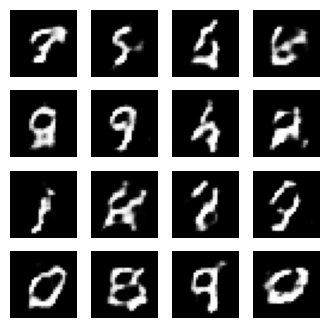

In [1]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    return tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128).prefetch(tf.data.AUTOTUNE)

def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model


def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model



def get_optimizers():
    return tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)

generator = build_generator()
discriminator = build_discriminator()
g_opt, d_opt = get_optimizers()
loss_fn = tf.keras.losses.BinaryCrossentropy()


# Discriminator wants real images as 1, fake images as 0
# Generator wants fake images to be classified as real (1)
@tf.function  # Compiles to a TensorFlow graph for speed
def train_step(images):
    noise = tf.random.normal([128, 100]) # creates a batch of 128 random noise vectors, each of size 100-dimensional

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # generator takes the random noise as input and produces fake images resembling real MNIST digits
        real_output = discriminator(images, training=True) # discriminator predicts whether real MNIST images are real (should be close to 1)
        fake_output = discriminator(generated_images, training=True) # discriminator predicts whether the generated (fake) images are real (should be close to 0)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output) # tf.ones_like(fake_output) creates a tensor of ones, representing "real" labels
                                                                   # loss_fn (Binary Crossentropy loss) measures how close fake_output is to 1
                                                                   # lower generator loss means the generator is successfully fooling the discriminator
                                                                   # higher generator loss means the generator is performing poorly
        disc_loss = (loss_fn(tf.ones_like(real_output), real_output) + # how well the discriminator classifies real images as real (close to 1)
                     loss_fn(tf.zeros_like(fake_output), fake_output)) # how well the discriminator classifies fake images as fake (close to 0)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # compute gradients for generator parameters
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # compute gradients for discriminator parameters

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # update the generator's weights
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # updates the discriminator's weight

    return gen_loss, disc_loss



def train(dataset, epochs=20):
    for epoch in range(epochs):
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")

def generate_and_show():
    noise = tf.random.normal([16, 100])
    images = generator(noise, training=False)
    images = (images + 1) / 2  # Rescale to [0,1]
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.show()

# Load data and train
mnist_data = load_data()
train(mnist_data, epochs=10)
generate_and_show()

The @tf.function decorator compiles the function into a TensorFlow computational graph. This makes execution significantly faster because:

TensorFlow optimizes the operations for GPUs.
It avoids Python overhead by compiling it into low-level operations.
It allows parallel execution where possible.
This is beneficial because training deep learning models is computationally intensive, and performance improvements matter.

Early Training: The generator is weak, so fake_output is low. gen_loss is high (because G is failing). The discriminator is strong, so disc_loss is low.

Mid Training: The generator improves, so fake_output increases. gen_loss starts decreasing. The discriminator gets confused, so disc_loss increases.

Late Training (Ideal Case): The generator is very strong, and fake_output ≈ real_output. The discriminator struggles, so both terms in disc_loss balance out. Both gen_loss and disc_loss settle near equilibrium.

tf.GradientTape() is a TensorFlow tool used for automatic differentiation, it helps compute gradients of operations with respect to variables.

How It Works -

Records operations: tf.GradientTape() keeps track of mathematical operations performed on tensors inside its with block.
Computes gradients: After executing operations, we can call .gradient(loss, variables) to compute gradients of the loss with respect to the model parameters.
Applies gradients: The computed gradients are then used by an optimizer (e.g., Adam) to update the model’s weights.
.shuffle(60000)

Randomly shuffles the dataset with a buffer size of 60000. Ensures that each batch gets a diverse mix of data, which helps with generalization.

.batch(128)

Groups the data into batches of 128 samples each for efficient processing. Instead of processing one sample at a time, the model processes 128 samples together.

.prefetch(tf.data.AUTOTUNE)

Optimizes data loading by prefetching batches in the background while the model is training. tf.data.AUTOTUNE allows TensorFlow to automatically decide the optimal number of batches to prefetch based on system resources.

# Discriminator is overpowering the generator (disc loss > 1.2), preventing it from learning **effectively**

In [ ]:
print("new project for new image dataset of humans")

# using FFHQ Gan ** **bold text**Templates**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Found 13233 files.
Epoch 1, Gen Loss: 4.0741, Disc Loss: 0.1441
Epoch 2, Gen Loss: 2.3096, Disc Loss: 1.0579
Epoch 3, Gen Loss: 2.1900, Disc Loss: 0.9694
Epoch 4, Gen Loss: 1.5420, Disc Loss: 0.7357
Epoch 5, Gen Loss: 2.0737, Disc Loss: 1.0099


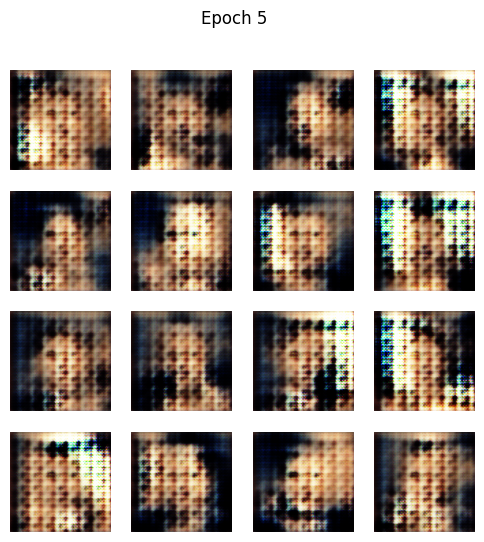

Epoch 6, Gen Loss: 1.3928, Disc Loss: 0.9858
Epoch 7, Gen Loss: 1.8477, Disc Loss: 0.4797
Epoch 8, Gen Loss: 2.8235, Disc Loss: 0.1662
Epoch 9, Gen Loss: 2.4540, Disc Loss: 0.6941
Epoch 10, Gen Loss: 3.4025, Disc Loss: 0.2382


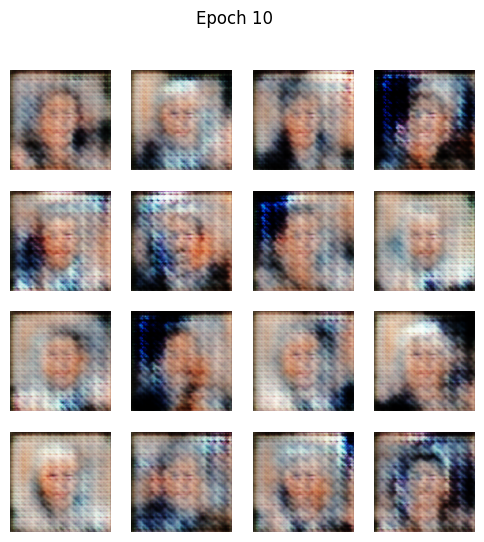

Epoch 11, Gen Loss: 2.5993, Disc Loss: 0.9674
Epoch 12, Gen Loss: 3.0835, Disc Loss: 0.2840
Epoch 13, Gen Loss: 3.1014, Disc Loss: 0.2958
Epoch 14, Gen Loss: 3.4684, Disc Loss: 0.3633
Epoch 15, Gen Loss: 2.4528, Disc Loss: 0.2014


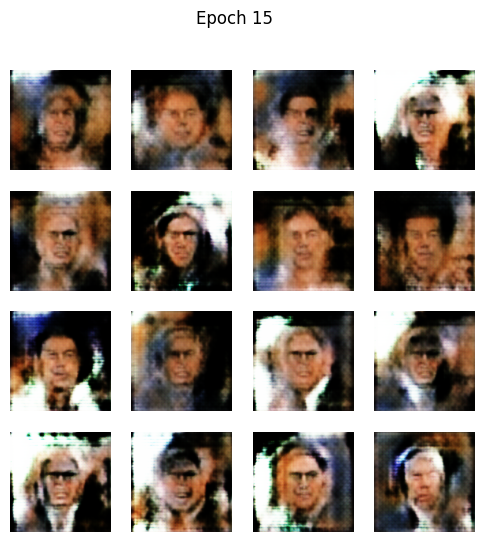

Epoch 16, Gen Loss: 3.4868, Disc Loss: 0.1658
Epoch 17, Gen Loss: 4.8113, Disc Loss: 0.3440
Epoch 18, Gen Loss: 6.0469, Disc Loss: 0.2191
Epoch 19, Gen Loss: 5.1600, Disc Loss: 0.0498
Epoch 20, Gen Loss: 3.1442, Disc Loss: 0.4259


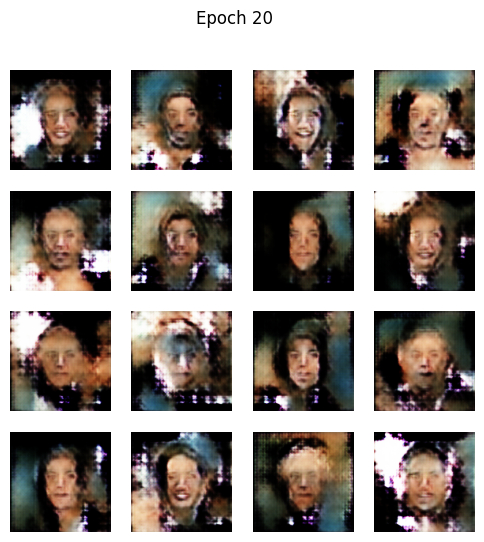

Epoch 21, Gen Loss: 3.0616, Disc Loss: 0.2753
Epoch 22, Gen Loss: 2.5635, Disc Loss: 0.2883
Epoch 23, Gen Loss: 2.6057, Disc Loss: 0.3938
Epoch 24, Gen Loss: 3.6551, Disc Loss: 0.6058
Epoch 25, Gen Loss: 3.0380, Disc Loss: 0.6287


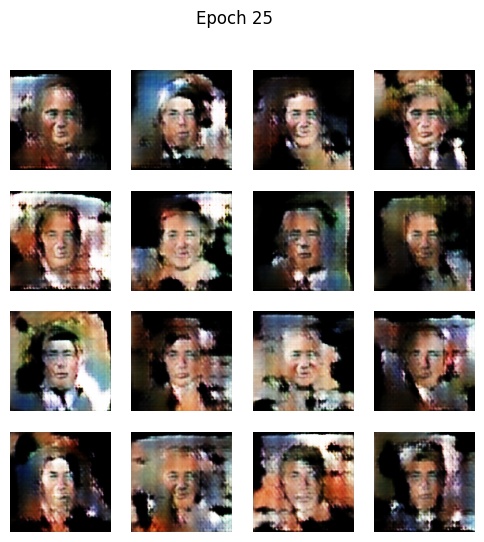

In [ ]:
# FFHQ GAN Template - 128x128 RGB images
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image

# -----------------------------
# 1. Load and preprocess FFHQ
# -----------------------------
# def load_ffhq(path, img_size=128, batch_size=32):
#     files = glob(os.path.join(path, "*.jpg"))  # FFHQ images are PNG
#     def preprocess(file_path):
#         img = tf.io.read_file(file_path)
#         img = tf.image.decode_png(img, channels=3)
#         img = tf.image.resize(img, [img_size, img_size])
#         img = (tf.cast(img, tf.float32) - 127.5) / 127.5  # normalize [-1,1]
#         return img
#     dataset = tf.data.Dataset.from_tensor_slices(files)
#     dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     return dataset
def load_lfw(img_size=128, batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "lfw_data/lfw-deepfunneled/",  # LFW path
        label_mode=None,               # GAN doesn’t need labels
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=True
    )
    # Normalize to [-1, 1]
    dataset = dataset.map(lambda x: (x / 127.5) - 1)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# -----------------------------
# 2. Generator
# -----------------------------
def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 512)),

        layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh')  # RGB output
    ])
    return model

# -----------------------------
# 3. Discriminator
# -----------------------------
def build_discriminator(img_size=128):
    model = tf.keras.Sequential([
        layers.Input(shape=(img_size,img_size,3)),

        layers.Conv2D(64, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# -----------------------------
# 4. Optimizers and Loss
# -----------------------------
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy()

# -----------------------------
# 5. Training step
# -----------------------------
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], latent_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss = (loss_fn(tf.ones_like(real_output), real_output) +
                     loss_fn(tf.zeros_like(fake_output), fake_output))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# -----------------------------
# 6. Training loop
# -----------------------------
def train(dataset, epochs=50):
    for epoch in range(epochs):
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")
        if (epoch+1) % 5 == 0:
            generate_and_show(epoch+1)

# -----------------------------
# 7. Generate images
# -----------------------------
def generate_and_show(epoch=None, num_images=16):
    noise = tf.random.normal([num_images, latent_dim])
    images = generator(noise, training=False)
    images = (images + 1) / 2  # [-1,1] -> [0,1]
    fig, axes = plt.subplots(4, 4, figsize=(6,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.suptitle(f'Epoch {epoch}' if epoch else '')
    plt.show()

# -----------------------------
# 8. Run
# -----------------------------
# Set path to your FFHQ images folder
ffhq_path = "lfw_data/lfw-deepfunneled/"  # LFW dataset path
  # change this
# ffhq_data = load_ffhq(ffhq_path, img_size=128, batch_size=32)
# ffhq_data = load_ffhq(ffhq_path, img_size=128, batch_size=32)

lfw_data = load_lfw(img_size=128, batch_size=32)
train(lfw_data, epochs=50)

# train(ffhq_data, epochs=50)  # can increase epochs for better results


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhaysrivastavaa","key":"8d0af88146a1a4783e815088608ca8c0"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d jessicali9530/lfw-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
  0% 0.00/112M [00:00<?, ?B/s]
100% 112M/112M [00:00<00:00, 1.31GB/s]


In [5]:
!unzip -q lfw-dataset.zip -d lfw_data
